In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [8]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

            prcp
date            
2016-08-23  0.00
2016-08-24  0.08
2016-08-25  0.08
2016-08-26  0.00
2016-08-27  0.00
...          ...
2017-08-17  0.13
2017-08-19  0.09
2017-08-21  0.56
2017-08-22  0.50
2017-08-23  0.45

[2021 rows x 1 columns]


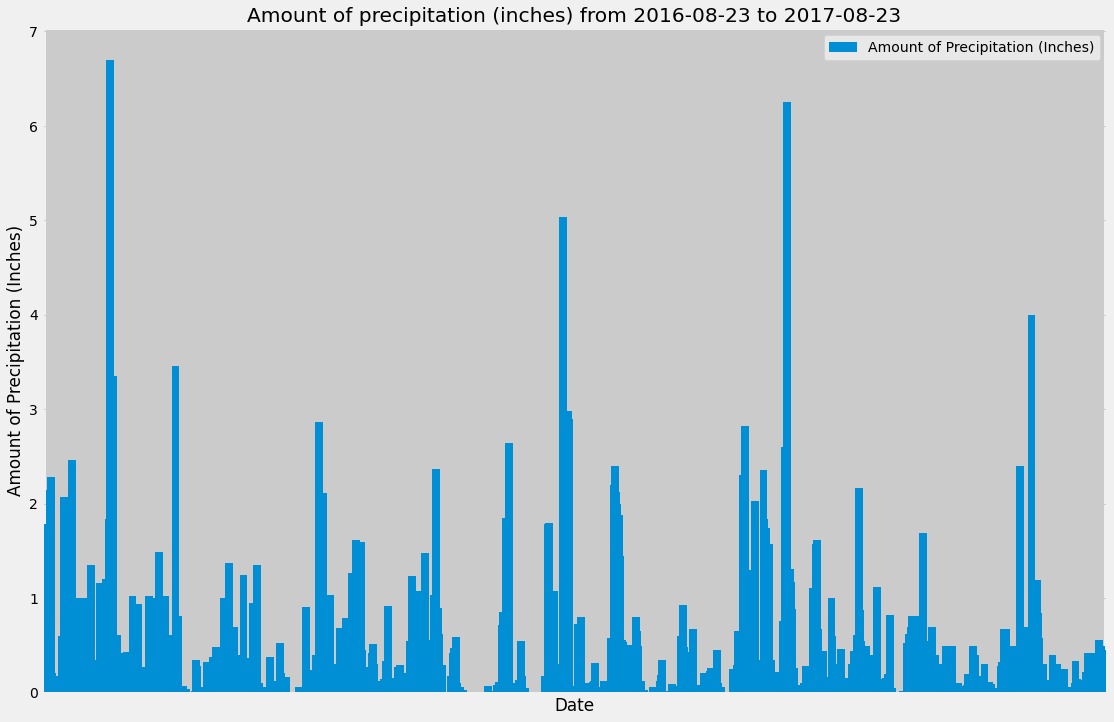

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_measurement_data_point_tuple = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
(latest_date, ) = last_measurement_data_point_tuple
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date = latest_date.date()
date_year_ago = latest_date - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores
data_from_last_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_data_df = pd.DataFrame(data_from_last_year, columns=['date', 'prcp'])

# Clean up
last_year_data_df = last_year_data_df.dropna(how="any")
last_year_data_df = last_year_data_df.set_index("date")
print(last_year_data_df)

# Sort the dataframe by date
last_year_data_df = last_year_data_df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
prcp_plot = last_year_data_df.plot(kind="bar", figsize=(15.7, 10.25), width=15)
prcp_plot.legend(["Amount of Precipitation (Inches)"], loc="upper right")
prcp_plot.set_xlabel("Date")
prcp_plot.set_ylabel("Amount of Precipitation (Inches)")
prcp_plot.set_title(f"Amount of precipitation (inches) from {date_year_ago} to {latest_date}")

plt.tick_params(
    axis='x',         
    which='both',    
    bottom=False,      
    top=False,        
    labelbottom=False
)
plt.tight_layout()
prcp_plot.grid(zorder=1)
plt.savefig(f"./Images/precipitation_data_from_{date_year_ago}_to_{latest_date}.png", bbox_inches='tight')
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_data_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
number_stations = session.query(Station.station).count()

print(f"Number of stations available in this dataset: {number_stations}")
number_stations_df = pd.DataFrame({ "Number of Stations": number_stations}, index=[0])
number_stations_df

Number of stations available in this dataset: 9


,Number of Stations
0,9


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station, func.count()).\
    group_by(Measurement.station).\
    order_by(func.count().desc()).\
    all()

for station, count in station_counts:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station).\
        group_by(Measurement.station).\
        order_by(func.count().desc()).\
        first()

(most_active_station_id, ) = most_active_station
print(f"The station id of the most active station is {most_active_station_id}.")

most_active_station_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == most_active_station_id) .\
        all()

for lowest_temp, highest_temp, avg_temp in most_active_station_data:
    print(f"The lowest temperature recorded at {most_active_station_id} was {lowest_temp}.")
    print(f"The highest temperature recorded at {most_active_station_id} was {highest_temp}.")
    print(f"The average temperature recorded at {most_active_station_id} was {avg_temp}.")
    
temperature_df = pd.DataFrame({
    "Lowest Temperature": lowest_temp,
    "Highest Temperature": highest_temp,
    "Average Temperature": avg_temp
}, index=[0])

temperature_df

The station id of the most active station is USC00519281.
The lowest temperature recorded at USC00519281 was 54.0.
The highest temperature recorded at USC00519281 was 85.0.
The average temperature recorded at USC00519281 was 71.66378066378067.


,Lowest Temperature,Highest Temperature,Average Temperature
0,54.0,85.0,71.663781


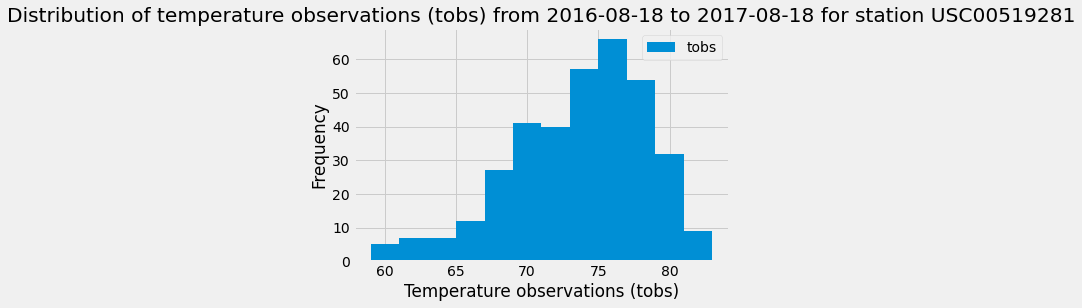

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
measurement_tuple = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
    filter(Measurement.station == most_active_station_id).first()

(latest_date,) = measurement_tuple
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date = latest_date.date()
date_year_ago = latest_date - relativedelta(years=1)

last_year_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= date_year_ago).all()
    
last_year_data_df = pd.DataFrame(last_year_data, columns=['date', 'tobs'])

last_year_data_df

plt.hist(last_year_data_df["tobs"], bins=12, label="tobs")
plt.ylabel('Frequency')
plt.xlabel('Temperature observations (tobs)')
plt.title(f"Distribution of temperature observations (tobs) from {date_year_ago} to {latest_date} for station {most_active_station_id}")
plt.grid(zorder=0)
plt.legend(loc="upper right")
plt.savefig(f"./Images/tobs_histogram_for_station_{most_active_station_id}.png", bbox_inches='tight')
plt.show()

# Close session

In [23]:
# Close Session
session.close()